# $$⚛ \space Quantum \space K-Means\space Clustering $$

In [77]:
from numpy import ndarray
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

from typing import Union, Optional

In [78]:
from qiskit.circuit.library import (
                        RXGate, RYGate, ZGate , XGate, YGate
                        )
from qiskit.visualization import array_to_latex

## Classical Clustering

- determine the number of clusters
- randomly initialize the centroids
- measure distances between data points and the centroids >> Fidelity
- assign data points to the nearest centroid
- update the position of the centroid according to the mean of each cluster

In [79]:
def kMeansInitCentroids(X : ndarray[float], K: int) -> ndarray[float]:
    """Initialize the centroids of the clusters.

    Returns an initial centroid for each cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, N)
        Data vector.

    K : int
        Number of clusters.

    Returns
    -------
    numpy.ndarray, shape=(K, N)
        Initial centroids.
    """

    m = X.shape[0]
    idx = np.random.choice(m, K, replace=False)
    centroids = X[idx]

    return centroids



def computeCentroids(X : ndarray[float] , idx : ndarray[int] , K : int = 2) -> ndarray[float] :
    """Update the centroids of the clusters.

    Returns a new centroid for each cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, N)
        Encoded Data vector.

    idx : numpy.ndarray, shape=(M, )
        Represent the cluster each point is assigned to.

    K : int
        Number of clusters.

    Returns
    -------
    numpy.ndarray, shape=(K, N)
        Updated centroids.
    """ 

    n = X.shape[1]
    centroids = np.zeros((K, n))

    for i in range(K):
        cluster_points = X[idx == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)

    return centroids


def findClosestCentroids(X : ndarray[float], centroids : ndarray[float]) -> ndarray[int]:
    """Find the closest centroids for each point.

    Returns an array where each point is assigned to the closest cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, N)
        Data vector.


    centroids : numpy.ndarray, shape=(K, N)
        Represent the encoded centroids.

    Returns
    -------
    numpy.ndarray, shape=(M, )
        Array where each point is assigned to the closest cluster.
    """ 
    m = X.shape[0]
    closest_centroids = np.zeros(m)

    for i in range(m):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        closest_centroids[i] = np.argmin(distances)

    return closest_centroids


def k_means(X : ndarray[float], k: int = 2, max_iter : int = 300) -> tuple[ndarray[float], ndarray[int]]:
    """K-Means algorithm for clustring the data into K clusters.

    Returns the centroids and an array where each point is assigned to the closest cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, N)
        Data vector.
        
    K : int
        Number of clusters.
        
    max_iter : int
        Number of iteration.
        

    Returns
    -------
    numpy.ndarray, shape=(K, N)
        The centroids.
    
    numpy.ndarray, shape=(M, )
        Array where each point is assigned to the closest cluster.
    """ 

    centroids = kMeansInitCentroids(X, k)
    for _ in range(max_iter):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, k)

    return centroids, idx

#### Create The Dataset

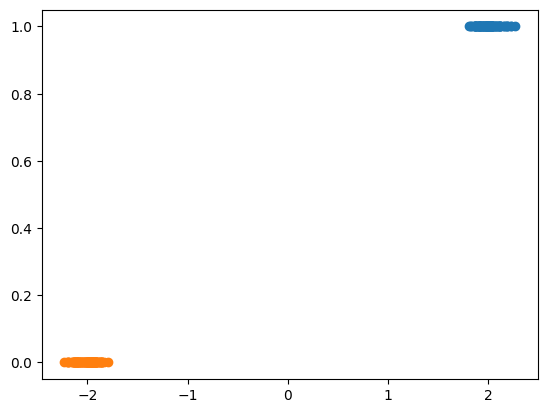

In [80]:
#### create the dataset
x1 = np.random.normal(2, 0.1, 100)
y1 = np.ones(len(x1))

x2 = np.random.normal(-2, 0.1, 100)
y2 = np.zeros(len(x2))


#### Visualize the dataset
plt.scatter(x1, y1)
plt.scatter(x2, y2);

### Testing Classical Clustering


In [81]:
#### Data preprocesing (concatenation)
X = np.concatenate((x1,x2)).reshape(-1,1)
Y = np.concatenate((y1,y2)).reshape(-1,1)
Data = np.concatenate((X,Y),axis = 1)

#### Validate the shapes
X.shape, Y.shape, Data.shape

((200, 1), (200, 1), (200, 2))

In [82]:
#### Running the Classical K-Means
centroids, idx = k_means(X, 2)

### Create Visualize Function

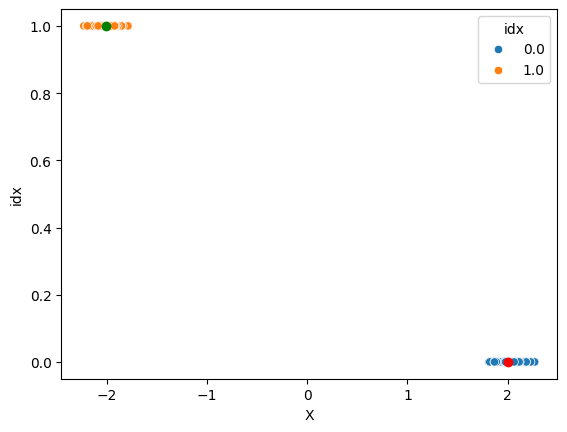

In [83]:
def visualize(X : ndarray[float], idx : ndarray[int], centroids : Union[ndarray[float], list]) -> Optional[AssertionError]:
    """Visualize the clusters and the centroid of each cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, 1)
        Encoded Data vector.

    idx : numpy.ndarray, shape=(M, )
        Represent the cluster each point is assigned to.

    centroids : numpy.ndarray, shape=(K, 1)
        Centroids of clusters.
    
    Notes
    -----
        This function only works with one feature.
    """

    assert X.shape[1] == 1, "This function only works with one feature"
    
    #### Visualize the clustered data
    df = pd.DataFrame(np.concatenate((X, idx.reshape(-1, 1)), axis=1), columns=['X', 'idx'])
    sns.scatterplot(data=df, x='X', y='idx', hue='idx')

    #### Plot the centroids
    plt.scatter(centroids[0], 0, c='red')
    plt.scatter(centroids[1], 1, c='green');

visualize(X, idx, centroids)

## Quantum Clustering

### Quantum Pre-processing

In [84]:
def init_state() -> ndarray:
    """Set the gound state (zero vector)

    Returns the zero vector

    -------
    numpy.ndarray, shape=(2, 1)
        Zero vector.
    """

    zero_vec = np.array([[1], [0]])

    return zero_vec


def encode_data(init_state : ndarray[complex] , x : ndarray[float]) -> ndarray[complex]:
    """Encode data on a qbit using rotatinal gate => RYGate()

    Parameters
    ----------
    init_state : numpy.ndarray, shape=(2, 1)
        The ground state.

    x : numpy.ndarray, shape=(M, 1) | (K, 1)
        Data vector or Centroids.

    Returns
    -------
    numpy.ndarray, shape=(M, 2, 1)
        The encoded data vector.
        
    Notes
    -------
    Here we start in an initial state ( zero vector) and apply a rotetinal gate
    on this state using the value of each data point.
    """

    evolved_state = []
    for point in x:
      ry = RYGate(float(point)).to_matrix()
      rotat = ry @ init_state   # shape (2,1)
      evolved_state.append(rotat)

    evolved_state = np.array(evolved_state)
    
    return evolved_state


def calc_fidelity(state1: ndarray[complex]  , state2 : ndarray[complex]) -> float :
    """Calculate the fidelity (inner product) between any two quantum states.

    Returns the fidelity between the encoded data point and the encoced centroid.

    Parameters
    ----------
    state1 : numpy.ndarray, shape=(2, 1)
        The first state.

    state2 : numpy.ndarray, shape=(2, 1)
        The second state.

    Returns
    -------
    float
        Inner product of the states.

    Notes
    -----
    the output should be a real scalar between 0 and 1.

    """
    
    return np.vdot(state1, state2).real


def measure(state : ndarray[complex], observable : ndarray[complex]) -> float:
    """Measure the state of the Qubit on the observable.

    Parameters
    ----------
    state : numpy.ndarray, shape=(2, 1)
        The state (Centroid).

    observable : numpy.ndarray, shape=(2, 2)
        The observable (ZGate).

    Returns
    -------
    float
        Classical output of the system.

    """
    
    return (state.conj().T @ observable @ state).real

#### Here we defined three essential functions to implement Quantum K-Means <br>
- The first function is *`init_state`*,  Assuming our initial state is always zero vector with shape `(2, 1)`.  why?

    - Because we have **one feuture** and a **singel Qubit** for encoding data in our system.<br>
- The second function is *`encode_data`* this function is used to encode both Data and centroids <br>
- The third function is *`calc_fidelity`* it only calculates the similarity between the data point and each cluster.<br>
- The fourth function is *`measure`* it converts the state of the quantum system to a **real classical value**.(`irreversible process`)

### Quantum K-Means
- determine the number of clusters
- randomly initialize the centroids
- measure distances between data points and the centroids >> Fidelity
  - Initialize three separable states in the ground state. One is for the data point and the other two represent the centroid.
  - choose your encoding scheme
  - using a for loop you will pick a classical point to measure the distance between the centroids and this sample.
  - encode the data using the encoding scheme (rotational gates)
  - apply the selected rotational gates on the states
  - then calculate the fidelity between the two states (one state would represent the data point and the other would represent the centroid)
- assign data points to the nearest centroid
- update the position of the centroid according to the mean of each cluster

In [85]:
def kMeansInitCentroidsQ(X : ndarray[float], K: int) -> ndarray[complex]:
    """Initialize the centroids of the clusters.

    Returns an initial centroid for each cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, 1)
        Data vector.

    K : int
        Number of clusters.

    Returns
    -------
    numpy.ndarray, shape=(K, 2, 1)
        Encoded initial centroids.
    """

    M = X.shape[0]
    choices = np.random.choice(M, K, replace=False)
    centroids = X[choices]
    init_state_arr = init_state()
    encoded_centroids = encode_data(init_state_arr, centroids )
    
    return encoded_centroids


def computeCentroidsQ(X : ndarray[complex] , idx : ndarray[int] , K : int = 2) -> ndarray[complex] :
    """Update the centroids of the clusters.

    Returns a new centroid for each cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, 1)
        Encoded Data vector.

    idx : numpy.ndarray, shape=(M, )
        Represent the cluster each point is assigned to.

    K : int
        Number of clusters.

    Returns
    -------
    numpy.ndarray, shape=(K, 2, 1)
        Updated centroids.
    """ 

    centroids = np.zeros((K, 2, 1), dtype=complex)

    for i in range(K):
      cluster_points = X[idx == i]
      if len(cluster_points) > 0:
          centroids[i] = np.mean(cluster_points, axis=0)
          
    return centroids


def findClosestCentroidsQ(X : ndarray[complex], centroids : ndarray[complex]) -> ndarray[int]:
    """Find the closest centroids for each point.

    Returns an array where each point is assigned to the closest cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, 1)
        Data vector.


    centroids : numpy.ndarray, shape=(K, 2, 1)
        Represent the encoded centroids.

    Returns
    -------
    numpy.ndarray, shape=(M, )
        Array where each point is assigned to the closest cluster.
    """ 
    M = X.shape[0]
    idx = np.zeros(M)

    
    for i in range(M):
        fids = []
        for cent in centroids:
            fidelity = calc_fidelity(X[i], cent)
            fids.append(fidelity)
        idx[i] = np.argmax(fids)

    return idx

In [86]:
def k_meansQ(X : ndarray[float], k: int = 2, max_iter : int = 300) -> tuple[ndarray[complex], ndarray[int]]:
    """K-Means algorithm for clustring the data into K clusters.

    Returns the centroids and an array where each point is assigned to the closest cluster.

    Parameters
    ----------
    X : numpy.ndarray, shape=(M, 1)
        Data vector.
        
    K : int
        Number of clusters.
        
    max_iter : int
        Number of iteration.
        

    Returns
    -------
    numpy.ndarray, shape=(K, 2, 1)
        Represent the encoded centroids.

    numpy.ndarray, shape=(M, 1)
        Array where each point is assigned to the closest cluster.
    """ 
    
    centroids = kMeansInitCentroidsQ(X, k)

    points_init_state = init_state()
    encoded_X = encode_data(points_init_state, X)

    for _ in range(max_iter):
        idx = findClosestCentroidsQ(encoded_X, centroids)
        centroids = computeCentroidsQ(encoded_X, idx, k)
        
    return centroids, idx

### Running Quantum K-Mean

In [87]:
centroids_encoded, idx = k_meansQ(X, 2, 200)

### Measuring Centroids

In [88]:
# hamiltonian or Observable
z_gate = ZGate().to_matrix()
y_gate = YGate().to_matrix()
x_gate = XGate().to_matrix()

z_gate.shape

(2, 2)

In [91]:
centroids = []
# centroids.append(measure(centroids_encoded[0], z_gate).squeeze())
# centroids.append(measure(centroids_encoded[1], z_gate).squeeze())
centroids.append(measure(centroids_encoded[0], x_gate).squeeze())
centroids.append(measure(centroids_encoded[1], x_gate).squeeze())
# centroids.append(measure(centroids_encoded[0], y_gate).squeeze())
# centroids.append(measure(centroids_encoded[1], y_gate).squeeze())
centroids

[array(-0.90413684), array(0.9060416)]

### Visualize The Clusters and the centroids

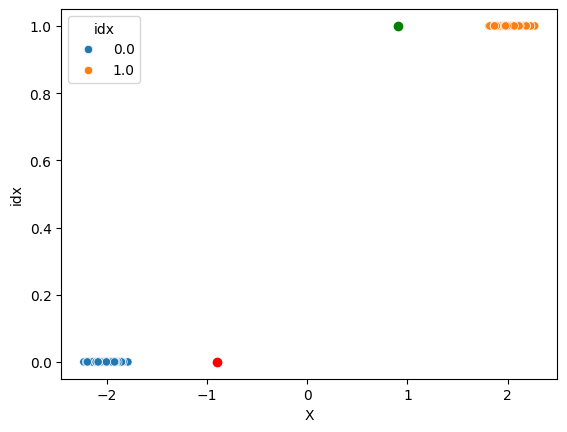

In [92]:
visualize(X, idx, centroids)

## Observations
- Enconding the date with RYGate -> results in a better clustring specially with measuring on the x-axis.
- The output of the quantum system when measured is constrained between `-1 and 1`, there for it will be better to scale the data in this range.
- Measuring on the same axis of encoding yeilds unuseful results.

---
$$ Good \space Luck ✨$$ 